In [33]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [34]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [35]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [36]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [37]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
Base.metadata.create_all(engine)

In [38]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [39]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [40]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [41]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [42]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
# Pick a year: year = 2016
year_2016 = calc_temps('2016-01-01', '2016-12-31')
print(f"Minimum temperature, average temperature and maxiumum temperature in year 2016: {year_2016}")

Minimum temperature, average temperature and maxiumum temperature in year 2016: [(56.0, 74.14421827631008, 84.0)]


In [43]:
year_2016 = calc_temps('2016-01-01', '2016-12-31')
year_2016

[(56.0, 74.14421827631008, 84.0)]

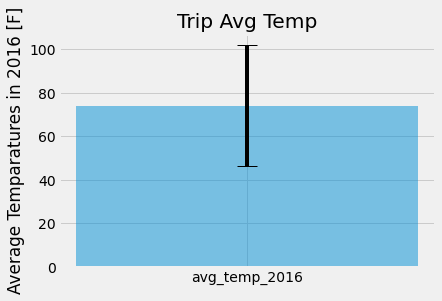

In [44]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

avg_temp_2016 = year_2016[0][1]
min_temp_2016 = year_2016 [0][0]
max_temp_2016 = year_2016 [0][2]

error = max_temp_2016 - min_temp_2016

x_axis = "avg_temp_2016"
fig, ax = plt.subplots()
ax.bar(x_axis, height = avg_temp_2016, yerr=error, width=0.5, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Average Temparatures in 2016 [F]')

ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)



### Daily Rainfall Average

In [45]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
#prcp
rain_2016 = session.query(Station.station,
                          Station.name,
                          func.sum(Measurement.prcp),
                          Station.latitude,
                          Station.longitude,
                          Station.elevation).\
                        filter(Measurement.date >= '2016-01-01').\
                        filter(Measurement.date <= '2016-12-31').\
                        group_by(Station.station).\
                        order_by(func.sum(Measurement.prcp).desc()).all()

rain_2016_df = pd.DataFrame(rain_2016, columns = ['Station',
                                                  'Name',
                                                  'Rainfall',
                                                  'Latitude',
                                                  'Longtude',
                                                  'Elevation'
                                                 ])
rain_2016_df.head() 


/var/folders/c1/_wjd1nqx03q7043fsjpcgjd80000gn/T/ipykernel_25169/356631639.py:5: SAWarning: SELECT statement has a cartesian product between FROM element(s) "measurement" and FROM element "station".  Apply join condition(s) between each element to resolve.
  rain_2016 = session.query(Station.station,


,Station,Name,Rainfall,Latitude,Longtude,Elevation
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",372.1,21.33556,-157.71139,19.5
1,USC00519397,"WAIKIKI 717.2, HI US",372.1,21.27160,-157.81680,3.0
2,USC00519281,"WAIHEE 837.5, HI US",372.1,21.45167,-157.84889,32.9
3,USC00518838,"UPPER WAHIAWA 874.3, HI US",372.1,21.49920,-158.01110,306.6
4,USC00517948,"PEARL CITY, HI US",372.1,21.39340,-157.97510,11.9


### Daily Temperature Normals

In [46]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
# Check 10th of May for each year:

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("10-05")

[(67.0, 76.16666666666667, 84.0)]

In [83]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2016-01-01'
end_date = '2016-01-16'

# Use the start and end date to create a range of dates
range_dates = pd.date_range(start='2016-01-01', end='2016-01-16', periods=16).astype(str)


# # Strip off the year and save a list of strings in the format %m-%d

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

days_range = []
for days in range(range_dates):
    days_range.append(days)
   
normals = []

def daily_norms(range_dates):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).all()

normals




TypeError: 'Index' object cannot be interpreted as an integer

In [82]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`


## Close Session

In [ ]:
close.session()